In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import string
#keras imports


Using TensorFlow backend.


## Data Analysis

In [3]:
df = pd.read_pickle('../lyrics.pkl', compression='gzip')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

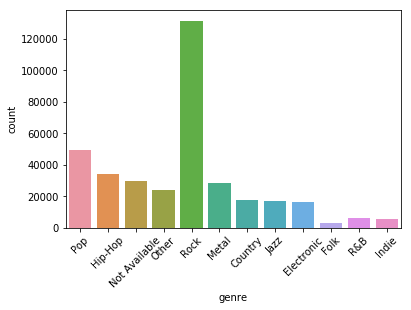

In [4]:
sns.countplot(df.genre)
plt.xticks(rotation=45)

Trimming dataset down to only Pop, Hip-Hip, Rock, and Metal

In [5]:
#probably a better way to do this
df = df[(df.genre == 'Pop') | (df.genre == 'Hip-Hop') | (df.genre == 'Metal') | (df.genre == 'Rock')]
df.dropna(inplace=True)
df.groupby('genre').nunique('genre')

,index,song,year,artist,genre,lyrics
genre,,,,,,
Hip-Hop,24850,21479,32,1107,1,22648
Metal,23759,21852,33,996,1,22498
Pop,40466,32443,47,2066,1,37229
Rock,109235,85240,48,3765,1,102512


We want an equal amount of data from each

4000


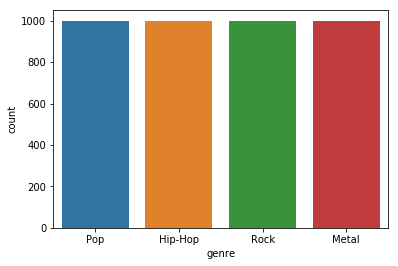

In [6]:
#also probably a better way to do this using 28408 because that is the smallest count
pop = df.loc[df['genre']=='Pop'].head(1000)
hiphop = df.loc[df['genre']=='Hip-Hop'].head(1000)
rock = df.loc[df['genre']=='Rock'].head(1000)
metal = df.loc[df['genre']=='Metal'].head(1000)
#really ratchet
output = pop.append(hiphop)
output = output.append(rock)
output = output.append(metal)
output.dropna(inplace=True)
output.reset_index(drop=True, inplace=True)
print(len(output))
#but it works...
sns.countplot(output.genre)

### creating the features and targets
the format will be lyrics: [the, bird, is, cool] target: [pop, pop, pop, pop]. Here the lyrics represents one song.

In [7]:
#removes spaces new line chars and returns the song as a list of words
def preprocess_song(lyrics):
    lyrics = lyrics.lower()
    table = lyrics.maketrans({key: None for key in string.punctuation})
    lyrics = lyrics.translate(table)
    lyrics = lyrics.replace('\n', " ")
    lyrics = lyrics.split(' ')
    #for some reason rstrip didnt work in all cases...
    return lyrics

#chunk songs into n-size chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

FINISHED PICKLING.


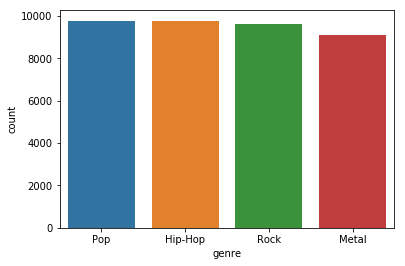

In [8]:

CHUNK_VAL = 10
chunk_df = pd.DataFrame(columns=['lyrics', 'genre'])
for i in range(len(output)):
    row = output.iloc[i]
    genre = row.genre
    lyrics = row.lyrics
    chunked_song = list(chunks(preprocess_song(lyrics), CHUNK_VAL))
    chunked_song = chunked_song[0:10]
    for chunk in chunked_song:
        chunk_dict = {'lyrics': chunk, 'genre': genre}
        chunk_df = chunk_df.append(chunk_dict, ignore_index=True)

chunk_df.to_pickle('10_word_seqs.pkl', compression='gzip')
print('FINISHED PICKLING.')
sns.countplot(chunk_df.genre)

### Save this df to a pickle for further processing

# Using Keras sequences to further format data

Currently all the songs are of different length we would like them all to be of the same length. We will do this by finding the length of the max song array and pad the rest of them to this size.

First we will encode our target variables in a one-hot encoding format. This is a really inefficient way of doing it, but my formatting was weird...

In [3]:
# genre_dict = {'Pop':[1,0,0,0], 'Hip-Hop':[0,1,0,0], 'Rock':[0,0,1,0], 'Metal':[0,0,0,1]}
# for val in range(len(out.genre)):
#     curr_genre = out.loc[val].genre[0]
#     genre_list = [genre_dict[curr_genre] for x in range(len(out.loc[val].genre))]
#     out.loc[val].genre = [genre_list]
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(out.genre)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

   
    

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


/Users/atallapr/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
y = onehot_encoded

In [5]:
#this value is the length of the longest song in our dataset.
len_vals = [len(x) for x in out.lyrics]
max_value = max(len_vals)
max_value

8196

In [6]:
max_words = 10000
max_len = max_value

Train tokenizer on our lyrics

In [7]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(out.lyrics)

Next we will create sequences of data. The output for our new features will be a padded sequence of numeric values each representing a unique word in our dataset

In [8]:
sequences = tok.texts_to_sequences(out.lyrics)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [9]:
#check to make sure length is 8196 
print(len(list(sequences_matrix[0])))
#reshape to 3-dimensional because thats how Dynamic RNNs like it.
sequences_matrix = sequences_matrix.reshape(90928, 8196,1)
print(sequences_matrix.shape)

8196
(90928, 8196, 1)


Now lets create our test/train split.

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(sequences_matrix,y,test_size=0.2)


In [ ]:
x_train = X_train.reshape(72742,8196)
x_test =  X_test.reshape(18186,8196)
with open('X_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, x_train)
    
with open('Y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, Y_train)
    
with open('X_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, x_test)

with open('Y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, Y_test)


Now lets build an RNN

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=X_train[0].shape)
    layer = LSTM(40)(inputs)
    layer = Dense(4, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model
#create instance of RNN
model = RNN()


In [ ]:
model.summary()

In [13]:
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
print("training begun...")
model.fit(X_train,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

training begun...
Train on 58193 samples, validate on 14549 samples
Epoch 1/10
  128/58193 [..............................] - ETA: 7:47:57 - loss: 1.4023 - acc: 0.1875

KeyboardInterrupt: 